In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

from converter.common_utils import hdf5_reader

# feature load

In [15]:
feature_path = './mid_feature/v2.0/1412.hdf5'
feature_in = hdf5_reader(feature_path,'feature_in')
feature_out = hdf5_reader(feature_path,'feature_out')
print(feature_in.shape,feature_out.shape)

(512, 64, 14, 14) (512, 1, 1, 1)


In [16]:
# print(np.max(feature_in))
# print(np.max(feature_out))
feature_out_ = feature_out.squeeze()
print(feature_out_.shape)

(512,)


# weight getter

In [17]:
def get_fc_weight(net,weight_path):
    checkpoint = torch.load(weight_path)
    net.load_state_dict(checkpoint['state_dict']) 
    fc_weight = net.fc.weight.detach().numpy()
    # print(type(fc_weight))
    return fc_weight
   

In [18]:
from model.resnet_3d import r3d_18,mc3_18
import torch
net = mc3_18(input_channels=1,num_classes=3)
weight_path = '../ckpt/v2.0/epoch:18-train_loss:0.30081-val_loss:0.25905.pth'

fc_weight = get_fc_weight(net,weight_path)
print(type(fc_weight))
print(fc_weight.shape)

<class 'numpy.ndarray'>
(3, 512)


# CAM

In [19]:
a = [np.sum(np.multiply(feature_out_,fc_weight[w])) for w in range(fc_weight.shape[0])]
def softmax(x):
    x_exp = np.exp(x)    
    x_sum = np.sum(x_exp,keepdims = True)
    s = x_exp / x_sum    
    return s
b = softmax(a)
print(b)

[2.4006926e-07 9.9999976e-01 8.9372891e-09]


In [20]:
heat_map_list = []
for j in range(fc_weight.shape[0]):
  heat_map_list.append([fc_weight[j][i]*feature_in[i] for i in range(feature_in.shape[0])])
heat_map = np.array(heat_map_list)
print(heat_map.shape)

(3, 512, 64, 14, 14)


In [21]:
heat_out = np.array([np.sum(heat_map[i],axis=0) for i in range(heat_map.shape[0])])
print(heat_out.shape)

(3, 64, 14, 14)


In [22]:
def normalize(img):
  img = (img - np.min(img))/(np.max(img) - np.min(img))
  return img

# image load

In [23]:
from converter.common_utils import hdf5_reader
from skimage.transform import resize
img_path = '../dataset/npy_data/NCP/1412.hdf5'
img = hdf5_reader(img_path,'img')
img = img[:,48:-48,48:-48]
img = resize(img,(64,224,224),anti_aliasing=True)

# Visualizaton

1
0


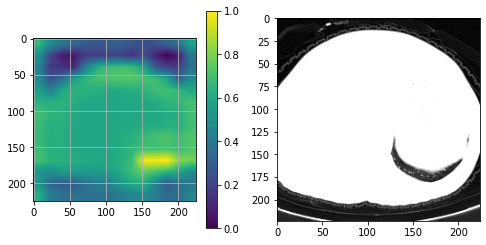

1


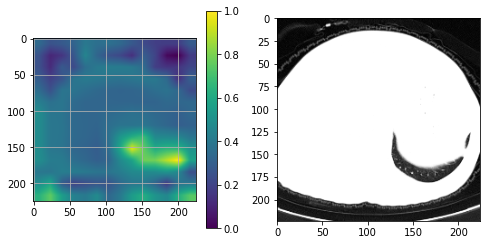

2


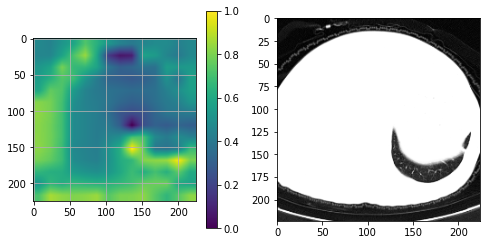

3


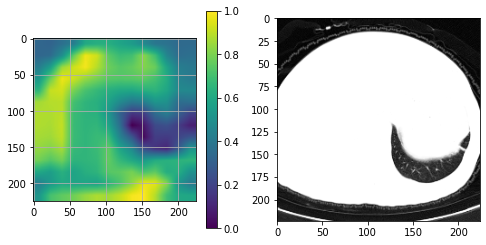

4


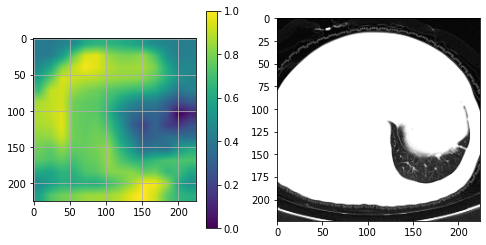

5


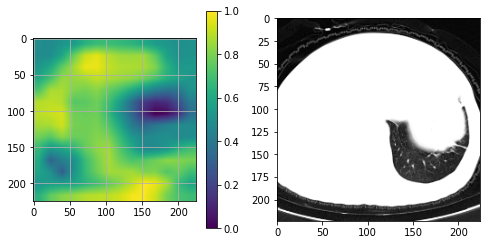

6


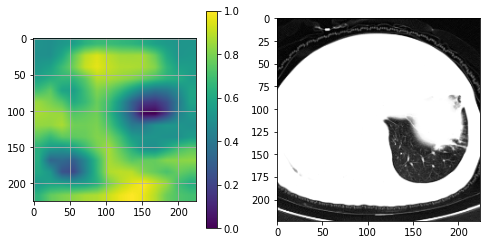

7


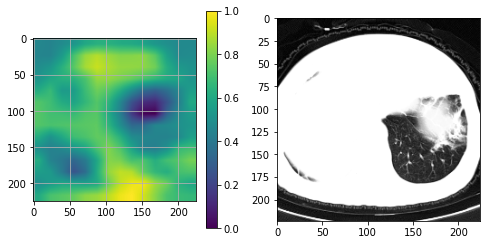

8


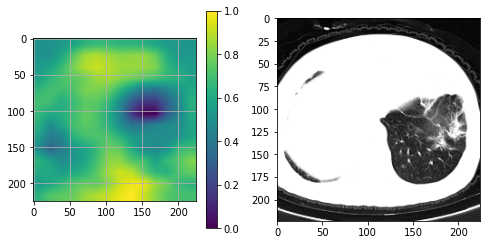

9


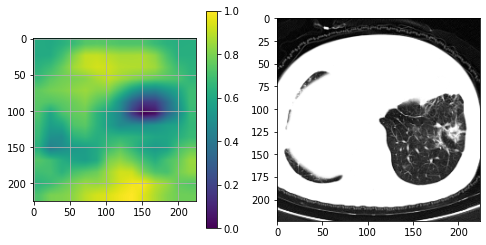

10


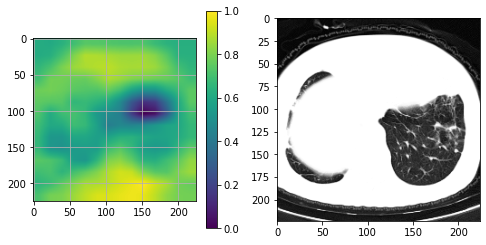

11


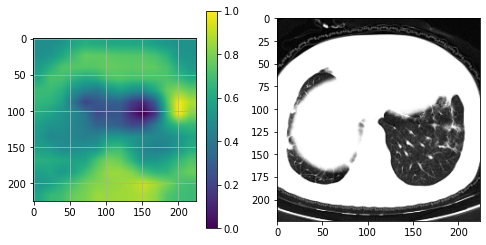

12


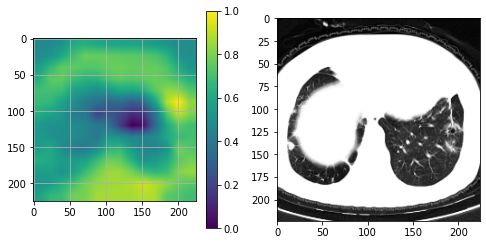

13


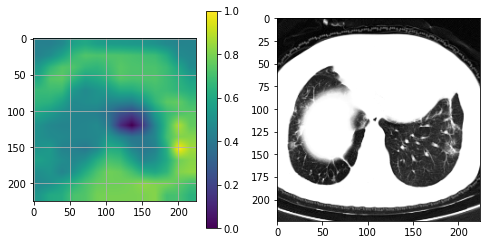

14


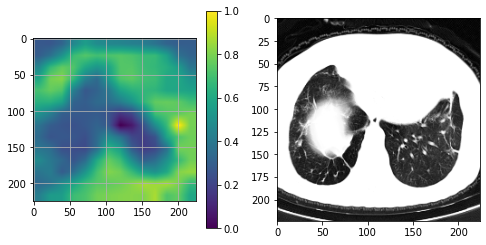

15


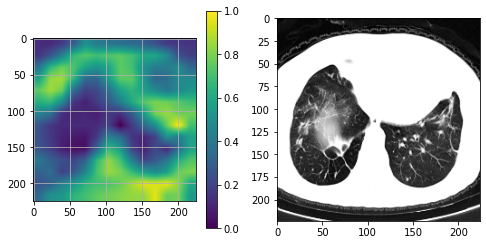

16


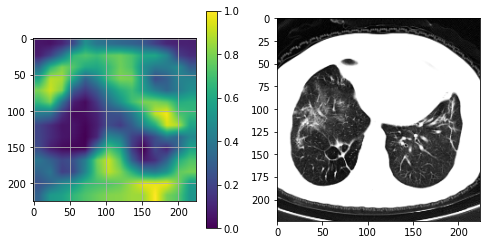

17


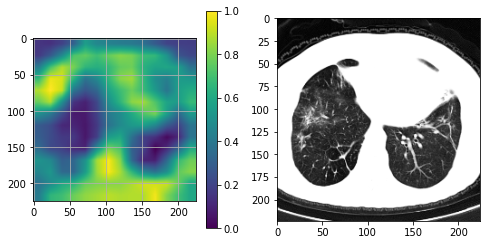

18


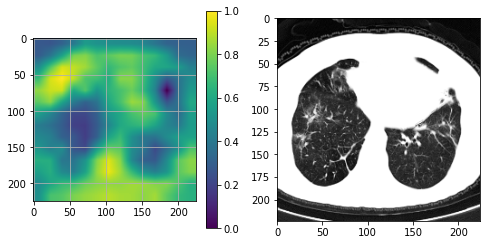

19


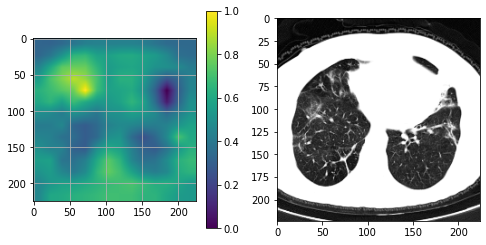

20


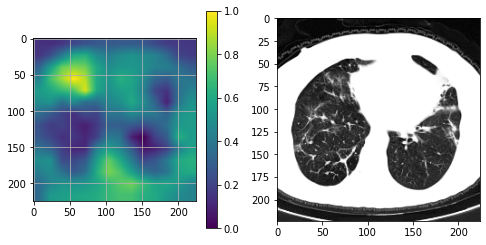

21


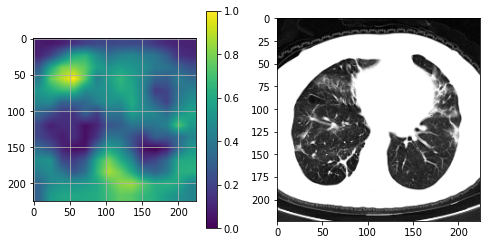

22


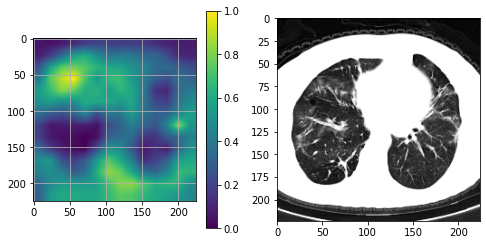

23


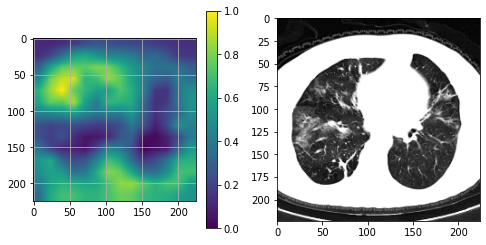

24


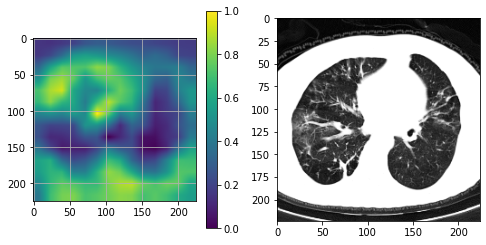

25


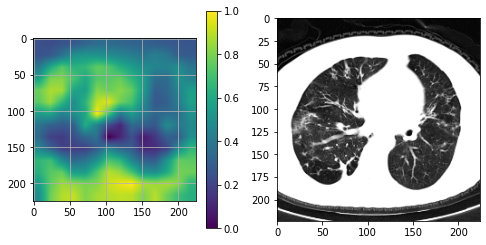

26


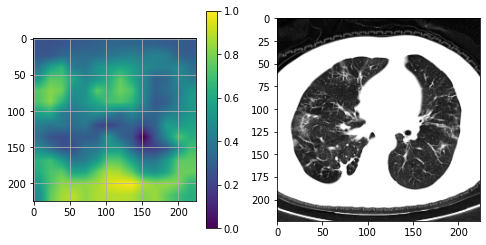

27


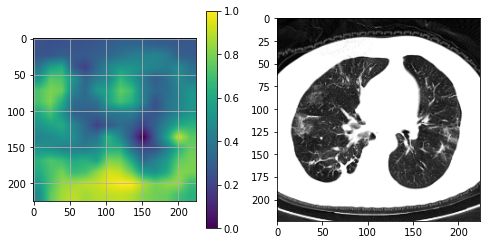

28


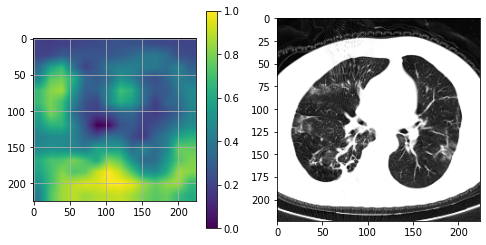

29


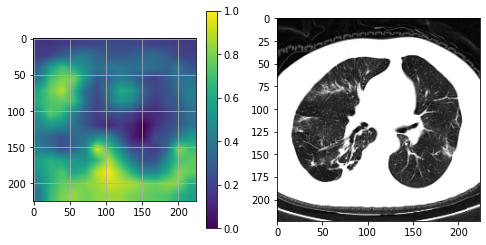

30


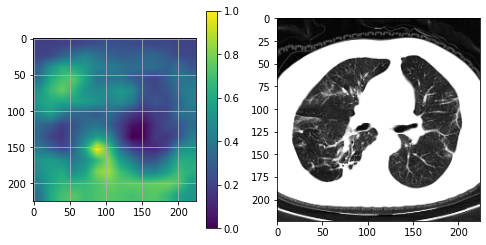

31


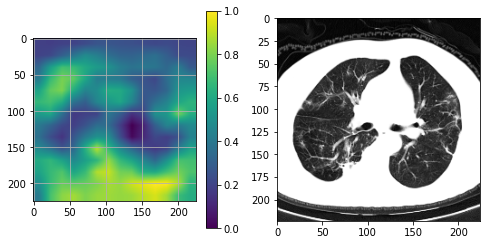

32


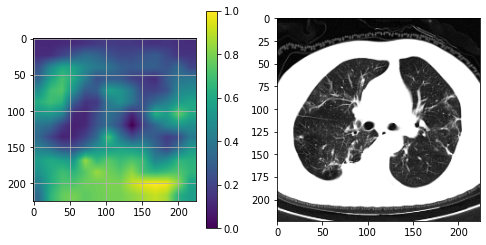

33


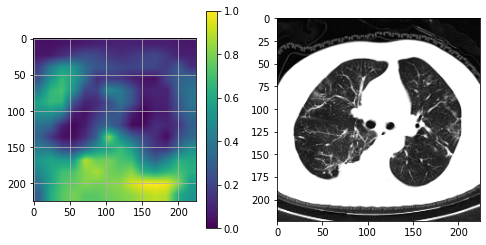

34


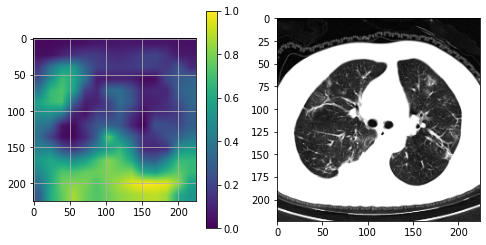

35


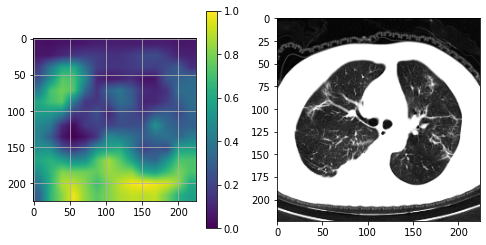

36


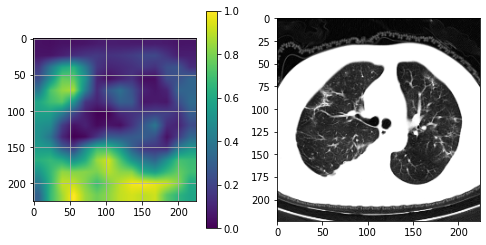

37


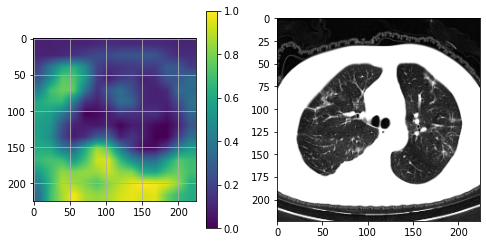

38


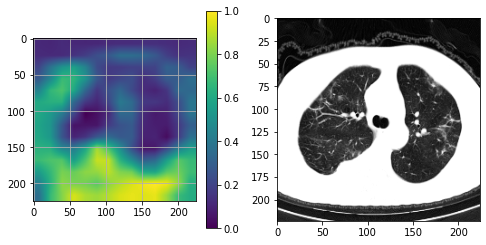

39


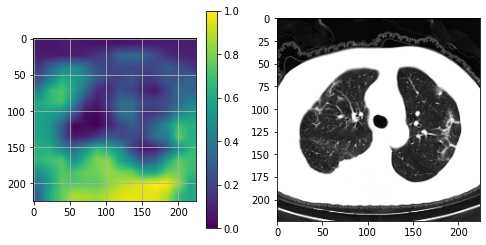

40


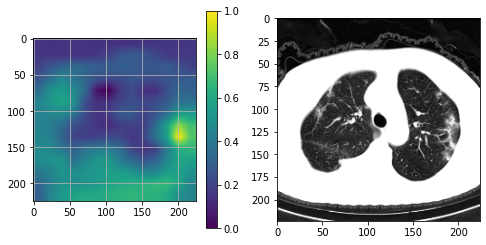

41


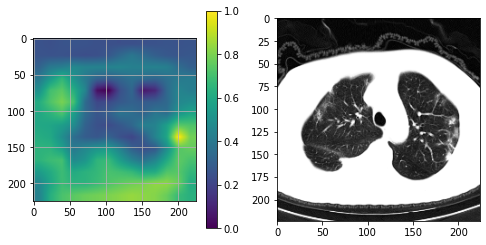

42


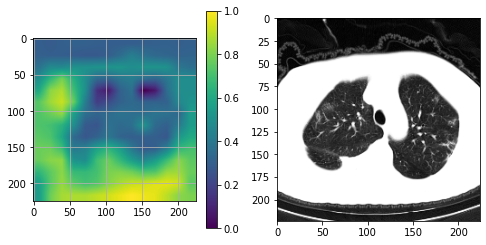

43


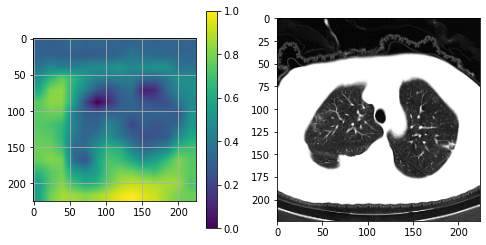

44


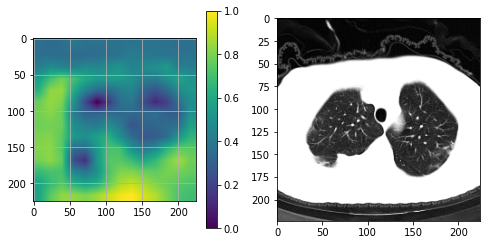

45


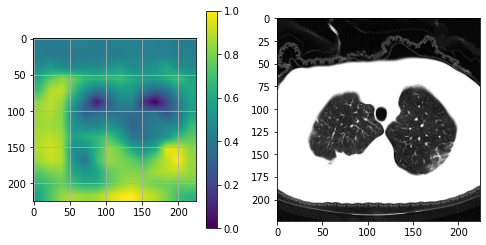

46


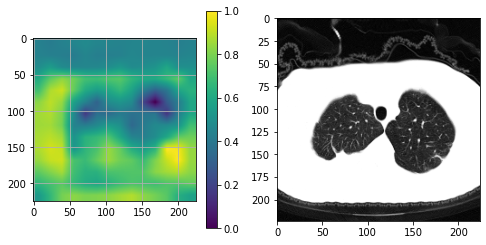

47


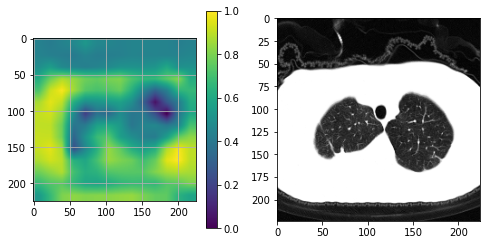

48


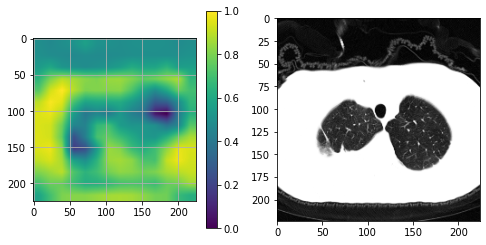

49


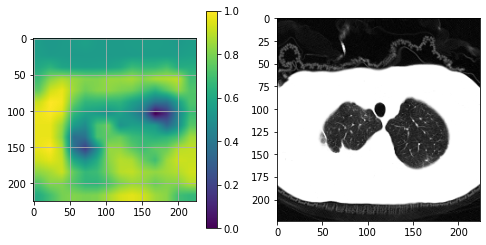

50


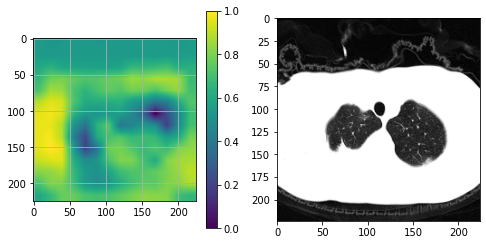

51


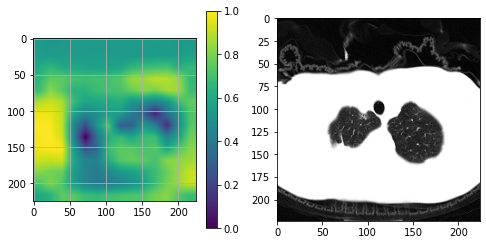

52


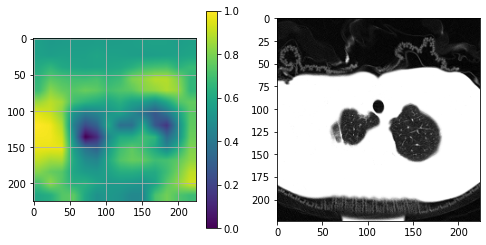

53


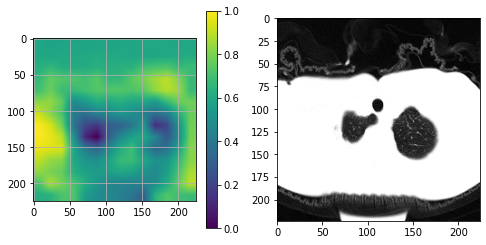

54


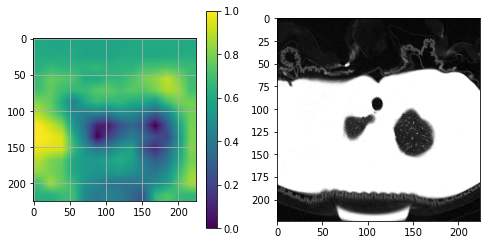

55


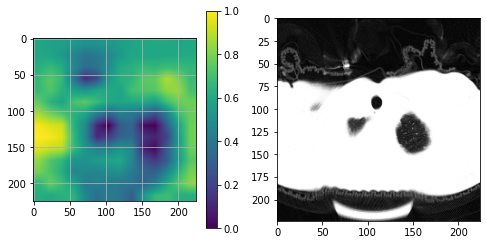

56


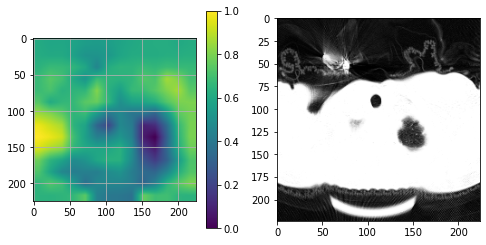

57


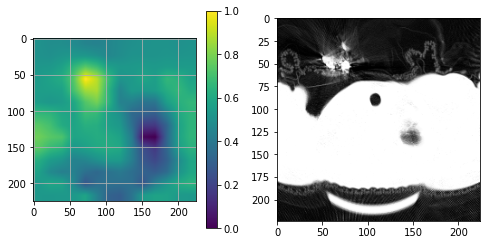

58


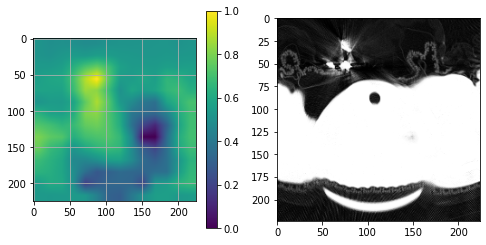

59


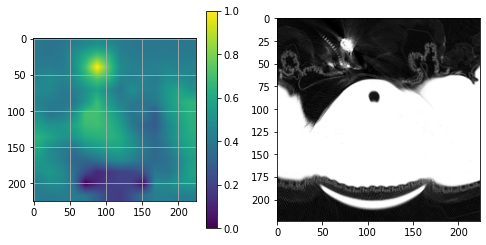

60


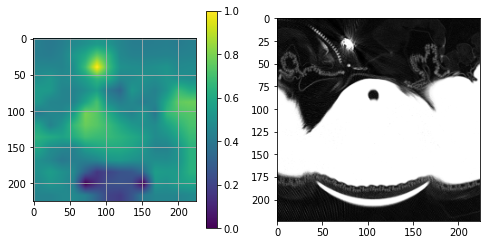

61


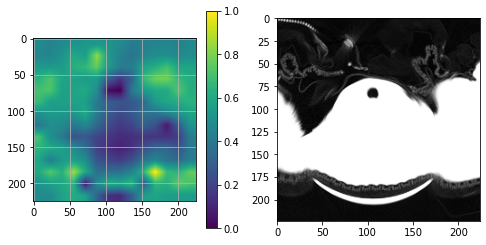

62


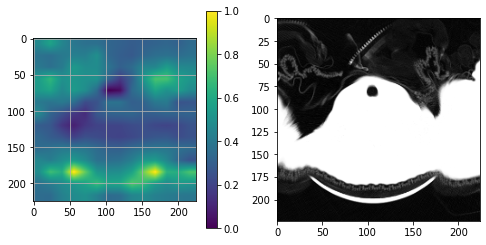

63


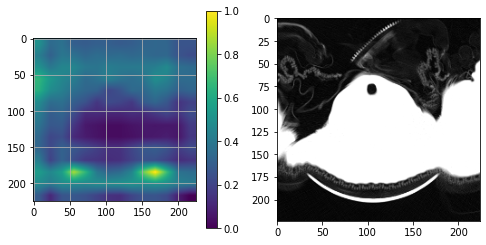

In [32]:
import cv2
index = np.argmax(b)
print(index)
item = heat_out[1]
# item = resize(item,(64,14,14))
for i in range(item.shape[0]):
    print(i)
    a = cv2.resize(item[i],(224,224),interpolation=cv2.INTER_LINEAR)
    a = normalize(a)
    # a[a < 0.5] = 0
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.imshow(a)
    plt.colorbar()
    plt.grid()
    plt.subplot(122)
    plt.imshow(img[i],cmap='gray')
    plt.axis('on')
    
    plt.show()